# I'm probably sampling Qval wrong and therefore getting data that's better than it should be

In [74]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Weak Tomography

How to perform weak tomography:

1. Spend half of your time in $Q_0(t)$ which yields information about the diagonal basis.
2. Spend 1/6 of your time in the three bases $e^{\delta L_i}Q_0(t)$ where $i=1,2,3$.

How to decode weak tomography:
    

Note that $L_i$ can be weak rotations around the three axes and that should be enough.

In [75]:
def testFAC(M):
    l = np.linalg.svd(M)[1]
    t1 = (1 - l[2]) >= np.abs(l[0] - l[1])
    t2 = (1 + l[2]) >= np.abs(l[0] + l[1])
    return t1 & t2

In [76]:
def sensormatrix(L):
    ridx = [0, 4, 8, 1, 2, 5]
    a1 = np.reshape(np.outer(L[:, 0], L[:, 0]), (9,1))[ridx, 0]
    a2 = np.reshape(np.outer(L[:, 1], L[:, 1]), (9,1))[ridx, 0]
    a3 = np.reshape(np.outer(L[:, 2], L[:, 2]), (9,1))[ridx, 0]
    S = np.c_[a1, a2, a3].T
    S[:, 3:6] = 2.0*S[:, 3:6]
    return S

def tomogn(Mval, n):
    mval = 0.5 * (1 - np.diag(Mval))
    T = np.array([[0, 1, 1], [1, 0, 1], [1, 1, 0]])
    Tinv = np.array([[-0.5, 0.5, 0.5], [0.5, -0.5, 0.5], [0.5, 0.5, -0.5]])
    pval = np.dot(Tinv, mval)
    pval = np.r_[1-np.sum(pval), pval]
    e = np.random.multinomial(n, pval)
    p = e / float(n)
    Mhat = np.diag(1.0 - 2.0 * np.dot(T, p[1:]))
    return Mhat

def weaktomog(Mval, n=100, d=0.5):
    L1 = np.array([[np.cos(d), -np.sin(d), 0], [np.sin(d), np.cos(d), 0], [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    Mval1 = np.dot(np.dot(L1.T, Mval), L1)
    Mval2 = np.dot(np.dot(L2.T, Mval), L2)
    Mval3 = np.dot(np.dot(L3.T, Mval), L3)
    Mhat1 = tomogn(Mval1, n)
    Mhat2 = tomogn(Mval2, n)
    Mhat3 = tomogn(Mval3, n)
    a = np.r_[np.diag(Mhat1), np.diag(Mhat2), np.diag(Mhat3)].T
    S = np.r_[sensormatrix(L1), sensormatrix(L2), sensormatrix(L3)]
    m = np.linalg.lstsq(S, a)[0]
    M = np.diag(m[0:3])
    M[0, 1], M[0, 2], M[1, 2] = m[3], m[4], m[5]
    M[1, 0], M[2, 0], M[2, 1] = m[3], m[4], m[5]
    return M

In [77]:
ncycles = []
dist = []
Mval_norms = []
Mhat_norms = []
Qnormdiffs = []
FACs = []
ds = []
for d in [0.05, 0.01, 0.005, 0.0001]:
    for trial in range(100):
        Qval, _ = np.linalg.qr(np.random.randn(3,3))
        Sval = np.diag([0.95, 0.9, 0.85])
        Mval = np.dot(np.dot(Qval, Sval), Qval.T)
        for n in np.logspace(1, 4, 30):
            Mhat = weaktomog(Mval, n=n, d=d)
            Qhat = np.linalg.svd(Mhat)[0]
            dist.append(np.linalg.norm(Mhat - Mval))
            ncycles.append(n)
            Mhat_norms.append(np.linalg.norm(Mhat))
            Mval_norms.append(np.linalg.norm(Mval))
            ds.append(d)
            Qnormdiffs.append(np.linalg.norm(np.dot(Qhat.T, Qval) - np.eye(3)))
            FACs.append(testFAC(Mhat))

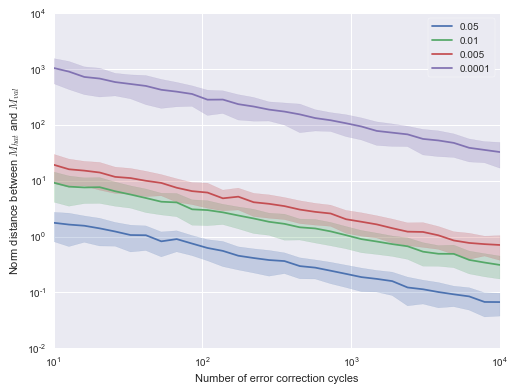

In [78]:
df = pd.DataFrame({"n": ncycles, "dist": dist, "d": ds})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.loglog(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Number of error correction cycles")

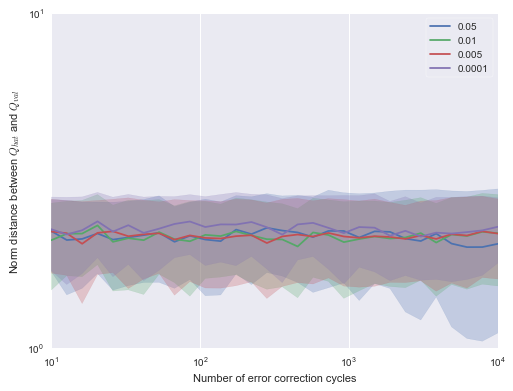

In [79]:
df = pd.DataFrame({"n": ncycles, "dist": Qnormdiffs, "d": ds})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.loglog(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $Q_{hat}$ and $Q_{val}$")
plt.xlabel("Number of error correction cycles")

In [22]:
df = pd.DataFrame({"n": ncycles, "FAC": FACs, "d": ds})
df.mean()

FAC       0.012250
d         0.016275
n      1571.431036
dtype: float64

In [23]:
Qval, _ = np.linalg.qr(np.random.random((3,3)))
Sval = np.diag([0.95, 0.9, 0.85])
Mval = np.dot(np.dot(Qval, Sval), Qval.T)
Mhat = weaktomog(Mval, n=100000, d=0.1)
Qhat = np.linalg.svd(Mhat)[0]

In [80]:
Mhat

array([[  0.88,   5.17, -20.5 ],
       [  5.17,   0.89,  26.83],
       [-20.5 ,  26.83,   0.93]])

In [24]:
Qval

array([[-0.04,  1.  ,  0.02],
       [-0.61, -0.01, -0.79],
       [-0.79, -0.04,  0.61]])

In [25]:
Qhat

array([[-0.12,  0.98, -0.16],
       [-0.64,  0.05,  0.77],
       [ 0.76,  0.19,  0.62]])

In [26]:
np.linalg.svd(Mhat)[1]

array([ 0.96,  0.9 ,  0.84])

## Need to restrict to Fujiwara-Algoet Condition

$$ (1 \pm \lambda_z)^2 \geq (\lambda_x \pm \lambda_y)^2 $$

The two separately are:

$$ 1 + 2 \lambda_z + \lambda_z^2 \geq \lambda_x^2 + 2 \lambda_x \lambda_y + \lambda_y^2 $$

$$ 1 - 2 \lambda_z + \lambda_z^2 \geq \lambda_x^2 - 2 \lambda_x \lambda_y + \lambda_y^2 $$

Or equivalently

$$ 1 + 2 (\lambda_z - \lambda_x\lambda_y) \geq \lambda_x^2 + \lambda_y^2 - \lambda_z^2 $$
$$ 1 - 2 (\lambda_z - \lambda_x\lambda_y) \geq \lambda_x^2 + \lambda_y^2 - \lambda_z^2 $$


## Reconstruct the process by evenly weighting the estimates

$$ M_{hat} = \frac{1}{3} L_1^T S_1 L_1 + \frac{1}{3} L_2^T S_2 L_2 + \frac{1}{3}  L_3^T S_3 L_3 $$

In [27]:
def eventomog(Mval, n=100, d=0.01):
    L1 = np.array([[np.cos(d), -np.sin(d), 0], [np.sin(d), np.cos(d), 0], [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    Mval1 = np.dot(np.dot(L1, Mval), L1.T)
    Mval2 = np.dot(np.dot(L2, Mval), L2.T)
    Mval3 = np.dot(np.dot(L3, Mval), L3.T)
    S1 = tomogn(Mval1, n)
    S2 = tomogn(Mval2, n)
    S3 = tomogn(Mval3, n)
    Mhat1 = np.dot(np.dot(L1.T, S1), L1)
    Mhat2 = np.dot(np.dot(L2.T, S2), L2)
    Mhat3 = np.dot(np.dot(L3.T, S3), L3)
    M = 1.0/3.0 * (Mhat1 + Mhat2 + Mhat3)
    return M

In [28]:
ncycles = []
dist = []
svd_dist = []
Qnormdiffs = []
FACs = []
ds = []
for d in 0.25*np.pi*np.logspace(0, -3, 4):
    for trial in range(100):
        Qval, _ = np.linalg.qr(np.random.randn(3,3))
        Sval = np.diag([0.95, 0.9, 0.85])
        Mval = np.dot(np.dot(Qval, Sval), Qval.T)
        for n in np.logspace(1, 6, 30):
            Mhat = eventomog(Mval, n=n, d=d)
            Qhat = np.linalg.svd(Mhat)[0]
            Mhatvals = np.linalg.svd(Mhat)[1]
            Mvalvals = np.linalg.svd(Mval)[1]
            dist.append(np.linalg.norm(Mhat - Mval))
            ncycles.append(n)
            svd_dist.append(np.linalg.norm(Mhatvals - Mvalvals))
            ds.append(d)
            Qnormdiffs.append(np.linalg.norm(np.dot(Qhat.T, Qval) - np.eye(3)))
            FACs.append(testFAC(Mhat))

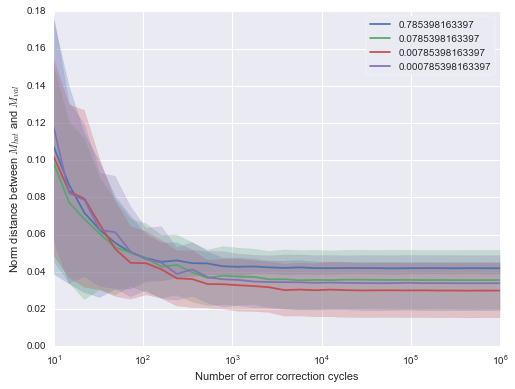

In [29]:
df = pd.DataFrame({"n": ncycles, "dist": svd_dist, "d": ds, "FAC": FACs})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.semilogx(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $M_{hat}$ and $M_{val}$")
plt.xlabel("Number of error correction cycles")

Holy flipping shit that is so much better.

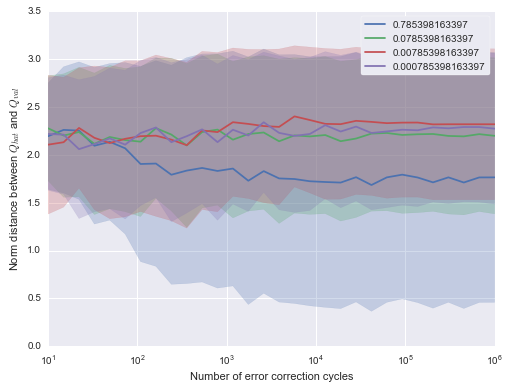

In [30]:
df = pd.DataFrame({"n": ncycles, "dist": Qnormdiffs, "d": ds, "FAC": FACs})
v = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.mean)
s = df.pivot_table(index="d", columns="n", values="dist", aggfunc=np.std)
dss = df["d"].unique()

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for idx, d in enumerate(dss):
    t = v.loc[d, :].index.values
    y = v.loc[d, :].values
    e = s.loc[d, :].values
    ax.semilogx(t, y, c=sns.color_palette()[idx], label=d)
    ax.fill_between(t, y-e, y+e, color=sns.color_palette()[idx], alpha=0.25)
plt.legend(frameon=True)
plt.ylabel("Norm distance between $Q_{hat}$ and $Q_{val}$")
plt.xlabel("Number of error correction cycles")

In [81]:
Qval, _ = np.linalg.qr(np.random.randn(3,3))
Sval = np.diag([0.95, 0.9, 0.85])
Mval = np.dot(np.dot(Qval, Sval), Qval.T)
Mhat = eventomog(Mval, n=10000000000, d=0.0001)
Qhat = np.linalg.svd(Mhat)[0]

np.dot(Qhat.T, Qval)

array([[ 0.67,  0.64, -0.38],
       [-0.55,  0.77,  0.32],
       [ 0.5 , -0.01,  0.87]])

In [82]:
Mhat

array([[  8.75e-01,   1.33e-06,  -1.15e-06],
       [  1.33e-06,   9.15e-01,  -1.79e-07],
       [ -1.15e-06,  -1.79e-07,   9.10e-01]])

In [83]:
Mval

array([[ 0.88,  0.03,  0.03],
       [ 0.03,  0.92,  0.01],
       [ 0.03,  0.01,  0.91]])

It is not better in terms of Q though...